# Market Making with Alpha Signals

## Pure Jump Process

In [2]:
import numpy as np
from matplotlib import pyplot as plt

In this case the poisson arrivals are created by simulating the entire T time and ordering those uniformly. This simulation is interpreting the Poisson process as a distribution of point counts. In this way time between arrivals have an exponential probability distribution.

117
[0 0 0 0 0 1 1 1 1 0 0 1 1 1 0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1
 0 1 1 1 0 0 1 1 0 0 0 0 1 1 0 1 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 0 0 1
 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 1 1 1 1 1
 0 1 1 0 0 1]
[-1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1 -1  1 -1  1 -1  1  1  1 -1 -1
 -1 -1 -1 -1  1  1 -1 -1  1  1 -1 -1  1 -1  1  1  1 -1 -1  1  1 -1 -1 -1
 -1  1  1 -1  1  1 -1  1  1  1 -1 -1 -1  1 -1  1 -1 -1  1 -1  1  1  1 -1
 -1  1  1  1  1 -1 -1  1  1  1  1  1  1 -1 -1  1  1  1  1 -1  1 -1 -1 -1
  1 -1  1  1 -1 -1 -1 -1  1 -1  1  1  1  1  1 -1  1  1 -1 -1  1]


(array([47., 28., 17.,  7.,  6.,  2.,  4.,  0.,  1.,  4.]),
 array([1.34368354e-03, 2.51790198e-01, 5.02236712e-01, 7.52683226e-01,
        1.00312974e+00, 1.25357625e+00, 1.50402277e+00, 1.75446928e+00,
        2.00491580e+00, 2.25536231e+00, 2.50580882e+00]),
 <BarContainer object of 10 artists>)

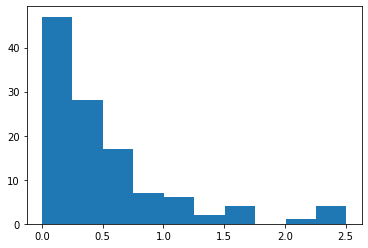

In [3]:
T=60
np.random.seed(1)
lambda_ = (1., 1.)
sigma = 1
number_of_market_orders=np.random.poisson(sum(lambda_) * T)
print(number_of_market_orders)
times = np.sort(np.random.uniform(size=number_of_market_orders)*T)
#print(times)
markers = np.random.binomial(n=1, p=lambda_[1] / sum(lambda_), size=number_of_market_orders)
jumps = np.where(markers == 0, -1, 1)
print(markers)
print(jumps)
s = sigma * np.cumsum(jumps)
plt.hist(np.diff(times))


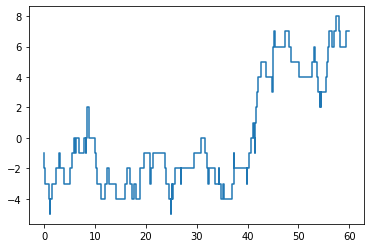

In [4]:
plt.step(times, s)

## Other way of simulating poisson arrivals

On the other hand, generating a random uniform variable for each dt will also generate a possion distribution if at each time we analyze the exponential probability distribution required. We are interpreting the poisson process as a counting process.

Thus, as for a Poisson process

$P(N_t - N_0 = n ) = \frac{(\lambda t)^n}{n!}e^{-\lambda t}$

Considering the probability of more than one arrival in dt negligible then

$P(N_t-N_{t-1}=n \neq 0)= \sum_{i=1}^{\infty} \frac{(\lambda dt)^i}{i!}e^{-\lambda dt}$

$P(N_t-N_{t-1}=n \neq 0)= 1-e^{-\lambda dt}$

which is the exponential distribution, as expected for the time of arrivales of a Poisson Process

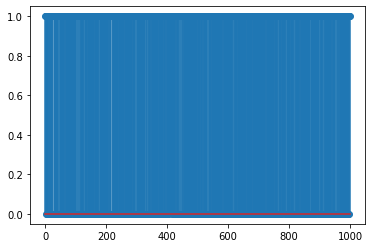

(array([381.,   0., 177.,   0.,  48.,   0.,  14.,   0.,   9.,   3.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <BarContainer object of 10 artists>)

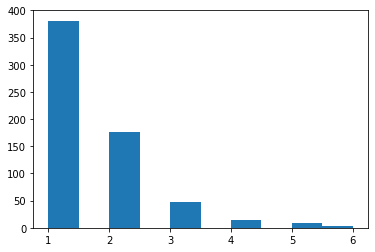

In [5]:
l = 1
n=1000
dt=1
arrivals = np.where(np.random.rand(n) < np.around((1 - np.exp(-dt * (l))), decimals=4),1,0)
plt.stem(arrivals)
plt.show()

t=np.array(range(n))
arrival_times = arrivals*t
arrival_times = arrival_times[arrival_times != 0]
arrival_times
distribution = np.diff(arrival_times)
plt.hist(distribution)

## dAlpha and dS as of Market Making with Alpha Signals

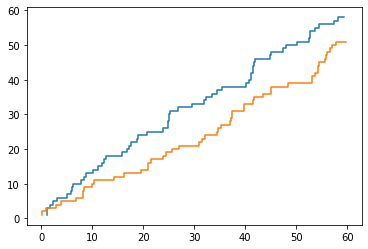

In [6]:
T=60
np.random.seed(1)
lambda_ = (1., 1.)
number_of_market_orders_buy=np.random.poisson(lambda_[0] * T)
number_of_market_orders_sell=np.random.poisson(lambda_[1] * T)
tau_plus = np.sort(np.random.uniform(size=number_of_market_orders_buy)*T)
tau_minus = np.sort(np.random.uniform(size=number_of_market_orders_sell)*T)
dMt_plus = np.ones(number_of_market_orders_buy)
dMt_minus = np.ones(number_of_market_orders_sell)
Mt_plus = dMt_plus.cumsum()
Mt_minus = dMt_minus.cumsum()
plt.step(tau_plus, Mt_plus)
plt.step(tau_minus, Mt_minus)


As in Jaimungal we can iterate in t but simulate across using an n size vector, generating n simulations at once.

Also since $d \alpha_t = -k \alpha_t dt$ then, $\alpha_t = c * e^{-k t}$

Alpha thus have a mean reverting component. 

I don't get why Jaimungal solves it using $\alpha_t = e^{-\zeta * dt} * \alpha_{t-1} $ since in the page 220 of AHFT solution is $\alpha_t = \alpha_0 e^{-k t}$

I guess since $\alpha_t = \alpha_0 e^{-k t}$, 

then

$\alpha_{t + dt} = \alpha_0 e^{-k (t+dt)}$

$\alpha_{t + dt} = \alpha_0 e^{-kt-k*dt}$

$\alpha_{t + dt} = \alpha_0 e^{-kt}e^{-k*dt}$

$\alpha_{t + dt} = \alpha_t e^{-k*dt}$

Condition as in paper:

$d\alpha_t=-k\alpha_t dt + \xi dW_t + \eta^+ (dM_t^{0+}+dM_t^+)-\eta^-(dMt_t^{0-}+dM_t^-), \alpha_0=0$


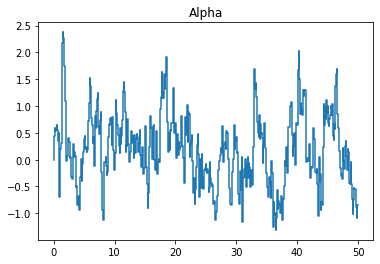

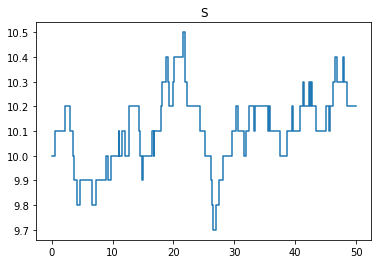

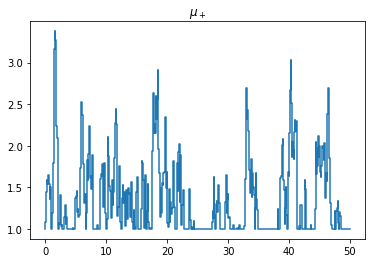

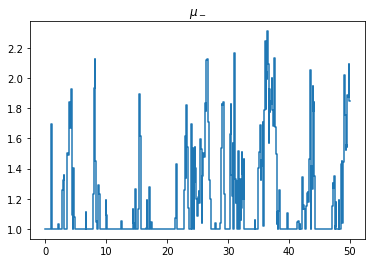

In [9]:
np.random.seed(1)
n = 10 # amount of simulations

# Alpha params
k = 1

eta_plus = 1
eta_minus = 1
lambda_plus = 0.1
lambda_minus = 0.1

T = 50
dt = 0.1


xi = 1
dMt_minus = 0
dMt_plus = 0

# S params
sigma = 0.1
theta = 1
s0 = 10

def generate_simulations(n, k, eta_plus, eta_minus, lambda_plus, lambda_minus, T, dt, xi, sigma, theta, s0, plot=False):
    m = int(T/dt)
    # Alpha setup
    alpha = np.full((n, m), np.nan)
    alpha[:, 0] = 0

    tau_plus_amounts = np.random.poisson(lambda_plus*T, n)
    tau_minus_amounts = np.random.poisson(lambda_minus*T, n)
    tau_plus = [np.sort(np.random.rand(tau_i) * T) for tau_i in tau_plus_amounts]
    tau_minus = [np.sort(np.random.rand(tau_i) * T) for tau_i in tau_minus_amounts]

    dMt0_plus = np.array([np.histogram(tau_i,np.linspace(0,T,m))[0] for tau_i in tau_plus])
    dMt0_minus = np.array([np.histogram(tau_i,np.linspace(0,T,m))[0] for tau_i in tau_minus])

    # S setup
    s = np.full((n, m), np.nan)
    s[:, 0] = s0

    mu_plus = np.full((n, m), np.nan)
    mu_plus[:, 0] = theta
    mu_minus = np.full((n, m), np.nan)
    mu_minus[:, 0] = theta

    dJ_plus = np.full((n, m), np.nan)
    dJ_plus[:, 0] = 0

    dJ_minus = np.full((n, m), np.nan)
    dJ_minus[:, 0] = 0

    # Simulations
    for i in range(m-1):
        # dMt_minus and dMt_plus depend on the MM
        alpha[:, i+1] = alpha[:,i] * np.exp(-k * dt) + xi * np.sqrt(dt) * (np.random.randn(n)) + eta_plus *(dMt0_plus[:,i] + dMt_plus) - eta_minus * (dMt0_minus[:,i] + dMt_minus)

        mu_plus[:, i+1] = np.where(alpha[:, i+1]>0, alpha[:, i+1],0) + theta
        mu_minus[:, i+1] = np.where(alpha[:, i+1]<0, -alpha[:, i+1],0) + theta

        dJ_plus[:, i+1] = np.where(np.random.rand(n) < (1 - np.exp(-dt * (mu_plus[:,i+1]))),1,0)
        dJ_minus[:, i+1] = np.where(np.random.rand(n) < (1 - np.exp(-dt * (mu_minus[:,i+1]))),1,0)
        
        s[:,i+1] = s[:,i] + sigma * (dJ_plus[:, i+1] - dJ_minus[:, i+1])

    if plot:
        plt_i = 0
        plt.title('Alpha')
        plt.step(np.linspace(0,T,m),alpha[plt_i])

        plt.figure()
        plt.title('S')
        plt.step(np.linspace(0,T,m),s[plt_i])
        # plt.stem(np.linspace(0,T,m),dJ_plus[plt_i]])

        plt.figure()
        plt.title('$\mu_+$')
        plt.step(np.linspace(0,T,m),mu_plus[plt_i])

        plt.figure()
        plt.title('$\mu_-$')
        plt.step(np.linspace(0,T,m),mu_minus[plt_i])
    return alpha, mu_plus, mu_minus, dJ_plus, dJ_minus, s
_ = generate_simulations(n, k, eta_plus, eta_minus, lambda_plus, lambda_minus, T, dt, xi, sigma, theta, s0, plot=True)

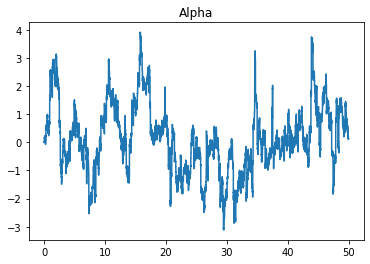

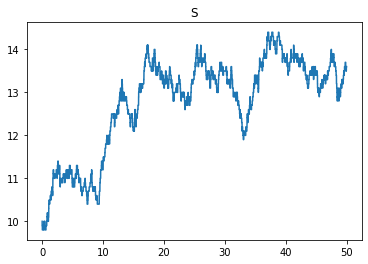

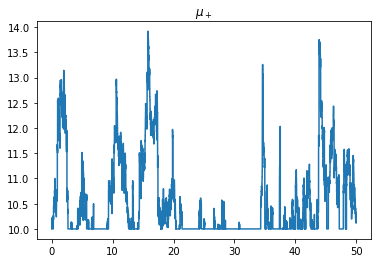

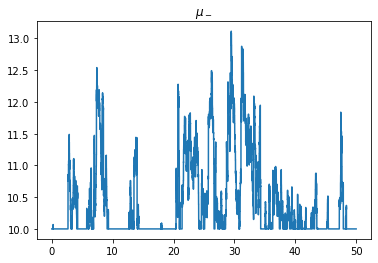

In [10]:
np.random.seed(1)
_ = generate_simulations(n=1, k=1, eta_plus=1, eta_minus=1, lambda_plus=1, lambda_minus=1, T=50, dt=0.01, xi=1, sigma=0.1, theta=10, s0=10, plot=True)

## Price Path Simulation with parameters as in MM with alpha signals paper (Figure 3 a, b)

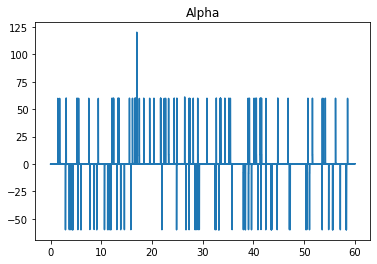

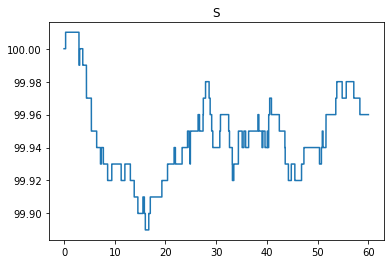

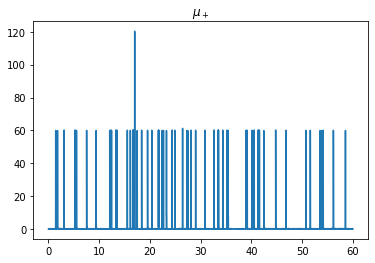

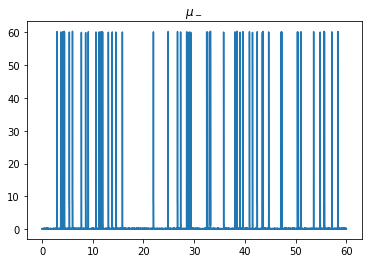

In [18]:
np.random.seed(3)
_ = generate_simulations(n=1, k=200, eta_plus=60, eta_minus=60, lambda_plus=1, lambda_minus=1, T=60, dt=0.01, xi=1, sigma=0.01, theta=0.1, s0=100, plot=True)

## H
$\Upsilon = \Delta + \epsilon$ where $\Delta$ is the market spread and $\epsilon \gt 0$ represents the exchange fee.

Problem:

...

Development of solution:

Terminal condition:

$H(T,x,S,\alpha,q)=x+q(S-sign(q)\Upsilon-\psi q)$

Solution:



$H(t,x,S,\alpha,q)=x+qS+\hat{h}(t,\alpha, q)$

with terminal condition:

$\hat{h}(T,\alpha, q)=q(-sign(q)\Upsilon-\psi q)$
